In [1]:
# Core Python libs
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset

# Scikit‑learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler

import xgboost as xgb

import joblib


In [2]:
# 1) Load & split the raw data
df = pd.read_csv("openSmile_emobase.csv")
feature_cols = [c for c in df.columns if c != "emotion"]
X_full = df[feature_cols]
y_full = df["emotion"]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.33,
    stratify=y_full,
    random_state=42
)

# 2) Global scaling (fit on train, apply to both)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# 3) Per‑emotion cumulative‐importance feature selection
emotions = ["happy", "angry", "disgust", "fearful", "neutral", "sad"]
cumulative_threshold = {
    "happy":    0.8,
    "angry":    0.5,
    "disgust":  0.8,
    "fearful":  0.5,
    "neutral":  0.6,
    "sad":      0.8
}

# Containers for emotion‑specific data and selected indices
emo_features = {}
X_train_emo  = {}
X_test_emo   = {}

for emo in emotions:
    # binary target: 1 if this emotion, else 0
    y_bin = (y_train == emo).astype(int)

    # fit tree‑based model to get importances
    etc = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    etc.fit(X_train, y_bin)
    importances = etc.feature_importances_

    # sort features by descending importance
    idx_sorted = np.argsort(importances)[::-1]
    cum_importance = np.cumsum(importances[idx_sorted])

    # find minimal set covering the threshold
    num_features = np.searchsorted(cum_importance, cumulative_threshold[emo]) + 1
    selected_idx = idx_sorted[:num_features]

    # store indices and slice scaled data
    emo_features[emo] = [feature_cols[i] for i in selected_idx]
    X_train_emo[emo] = X_train[:, selected_idx]
    X_test_emo[emo] = X_test[:, selected_idx]

    print(f"{emo}: selected {num_features} features covering {cumulative_threshold[emo]*100:.0f}% importance")

happy: selected 695 features covering 80% importance
angry: selected 319 features covering 50% importance
disgust: selected 687 features covering 80% importance
fearful: selected 352 features covering 50% importance
neutral: selected 405 features covering 60% importance
sad: selected 683 features covering 80% importance


In [3]:
# joblib.dump(scaler, "D_EmoScaler.pkl")
# joblib.dump(emo_features["disgust"], "disgust_features.pkl")
print(X_train)

[[ 0.20051951 -0.29087151  0.20068077 ...  0.85654987 -0.05835925
   0.36518685]
 [ 1.75464923 -0.30460789  1.75486933 ...  0.00884327 -0.04229745
  -0.02065442]
 [-0.69401092 -0.31528689 -0.69386643 ... -0.81393678 -0.93871881
  -0.92940236]
 ...
 [ 0.30199994 -0.29455885  0.30216647 ... -0.23764047  1.37047068
   0.69201431]
 [-0.69992313 -0.31528689 -0.69977883 ... -0.23410703 -0.93871881
  -0.65905197]
 [ 1.22732984  2.29097946  1.22615312 ... -0.81393678 -0.93871881
  -0.92940236]]


In [4]:

# for emo in emotions:
#         joblib.dump(emo_features[emo], emo + "_features.pkl")

In [5]:
class BinaryMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64):
        super(BinaryMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# ─── Block: Train "happy" binary classifier ───

y_train_h = np.where(y_train == "happy", 1, 0)
y_test_h  = np.where(y_test  == "happy", 1, 0)

model_happy_svc = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=True,
    random_state=42
)
model_happy_svc.fit(X_train_emo["happy"], y_train_h)
y_pred_happy = model_happy_svc.predict(X_test_emo["happy"])
print(classification_report(y_test_h, y_pred_happy, target_names=["not happy","happy"]))


              precision    recall  f1-score   support

   not happy       0.93      0.92      0.92       530
       happy       0.62      0.66      0.64       107

    accuracy                           0.87       637
   macro avg       0.77      0.79      0.78       637
weighted avg       0.88      0.87      0.88       637



Epoch 1/50 — Loss: 0.4158
Epoch 2/50 — Loss: 0.2822
Epoch 3/50 — Loss: 0.2051
Epoch 4/50 — Loss: 0.1369
Epoch 5/50 — Loss: 0.1087
Epoch 6/50 — Loss: 0.0698
Epoch 7/50 — Loss: 0.0375
Epoch 8/50 — Loss: 0.0321
Epoch 9/50 — Loss: 0.0200
Epoch 10/50 — Loss: 0.0213
Epoch 11/50 — Loss: 0.0077
Epoch 12/50 — Loss: 0.0022
Epoch 13/50 — Loss: 0.0008
Epoch 14/50 — Loss: 0.0005
Epoch 15/50 — Loss: 0.0004
Epoch 16/50 — Loss: 0.0003
Epoch 17/50 — Loss: 0.0003
Epoch 18/50 — Loss: 0.0002
Epoch 19/50 — Loss: 0.0002
Epoch 20/50 — Loss: 0.0002
Epoch 21/50 — Loss: 0.0002
Epoch 22/50 — Loss: 0.0001
Epoch 23/50 — Loss: 0.0001
Epoch 24/50 — Loss: 0.0001
Epoch 25/50 — Loss: 0.0001
Epoch 26/50 — Loss: 0.0001
Epoch 27/50 — Loss: 0.0001
Epoch 28/50 — Loss: 0.0001
Epoch 29/50 — Loss: 0.0001
Epoch 30/50 — Loss: 0.0001
Epoch 31/50 — Loss: 0.0001
Epoch 32/50 — Loss: 0.0001
Epoch 33/50 — Loss: 0.0001
Epoch 34/50 — Loss: 0.0001
Epoch 35/50 — Loss: 0.0000
Epoch 36/50 — Loss: 0.0000
Epoch 37/50 — Loss: 0.0000
Epoch 38/5

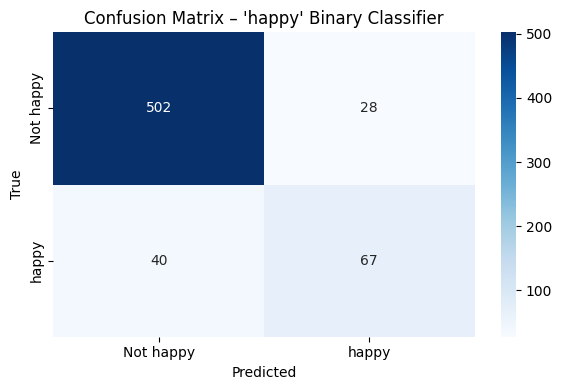

In [9]:
# ─── Block: Train "happy" binary classifier ───

# Hyperparameters
input_dim   = X_train_emo['happy'].shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
lr          = 1e-3
batch_size  = 32
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare DataLoaders
X_happy_train = torch.tensor(X_train_emo['happy'], dtype=torch.float32)
y_happy_train = torch.tensor((y_train == 'happy').astype(float), dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_happy_train, y_happy_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_happy_test  = torch.tensor(X_test_emo['happy'], dtype=torch.float32)
y_happy_test  = torch.tensor((y_test.to_numpy()  == 'happy').astype(float), dtype=torch.float32).unsqueeze(1)
test_ds  = TensorDataset(X_happy_test, y_happy_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Instantiate model, loss, and optimizer
model_happy = BinaryMLP(input_dim, hidden_dim1, hidden_dim2).to(device)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(model_happy.parameters(), lr=lr)

# Training loop
for epoch in range(1, num_epochs+1):
    model_happy.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_happy(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")

# Evaluation
model_happy.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model_happy(xb).cpu().numpy()
        preds = (probs > 0.3).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(yb.numpy().flatten().tolist())


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['not happy', 'happy']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()


Epoch 1/50 — Loss: 0.3771
Epoch 2/50 — Loss: 0.2500
Epoch 3/50 — Loss: 0.1924
Epoch 4/50 — Loss: 0.1366
Epoch 5/50 — Loss: 0.1243
Epoch 6/50 — Loss: 0.0788
Epoch 7/50 — Loss: 0.0976
Epoch 8/50 — Loss: 0.0614
Epoch 9/50 — Loss: 0.0545
Epoch 10/50 — Loss: 0.0272
Epoch 11/50 — Loss: 0.0126
Epoch 12/50 — Loss: 0.0055
Epoch 13/50 — Loss: 0.0028
Epoch 14/50 — Loss: 0.0014
Epoch 15/50 — Loss: 0.0011
Epoch 16/50 — Loss: 0.0008
Epoch 17/50 — Loss: 0.0007
Epoch 18/50 — Loss: 0.0005
Epoch 19/50 — Loss: 0.0005
Epoch 20/50 — Loss: 0.0004
Epoch 21/50 — Loss: 0.0004
Epoch 22/50 — Loss: 0.0003
Epoch 23/50 — Loss: 0.0003
Epoch 24/50 — Loss: 0.0003
Epoch 25/50 — Loss: 0.0002
Epoch 26/50 — Loss: 0.0002
Epoch 27/50 — Loss: 0.0002
Epoch 28/50 — Loss: 0.0002
Epoch 29/50 — Loss: 0.0002
Epoch 30/50 — Loss: 0.0001
Epoch 31/50 — Loss: 0.0001
Epoch 32/50 — Loss: 0.0001
Epoch 33/50 — Loss: 0.0001
Epoch 34/50 — Loss: 0.0001
Epoch 35/50 — Loss: 0.0001
Epoch 36/50 — Loss: 0.0001
Epoch 37/50 — Loss: 0.0001
Epoch 38/5

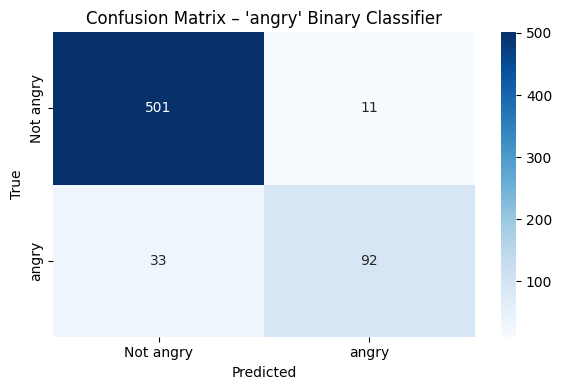

In [11]:
# ─── Block: Train "angry" binary classifier ───

# Hyperparameters
input_dim   = X_train_emo['angry'].shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
lr          = 1e-3
batch_size  = 32
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare DataLoaders
X_angry_train = torch.tensor(X_train_emo['angry'], dtype=torch.float32)
y_angry_train = torch.tensor((y_train == 'angry').astype(float), dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_angry_train, y_angry_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_angry_test  = torch.tensor(X_test_emo['angry'], dtype=torch.float32)
y_angry_test  = torch.tensor((y_test.to_numpy()  == 'angry').astype(float), dtype=torch.float32).unsqueeze(1)
test_ds  = TensorDataset(X_angry_test, y_angry_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Instantiate model, loss, and optimizer
model_angry = BinaryMLP(input_dim, hidden_dim1, hidden_dim2).to(device)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(model_angry.parameters(), lr=lr)

# Training loop
for epoch in range(1, num_epochs+1):
    model_angry.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_angry(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")

# Evaluation
model_angry.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model_angry(xb).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(yb.numpy().flatten().tolist())


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['not angry', 'angry']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"angry"}", "angry"],
    yticklabels=[f"Not {"angry"}", "angry"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"angry"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [13]:
# ─── Block: Train "disgust" binary classifier ───

y_train_d = np.where(y_train == "disgust", 1, 0)
y_test_d  = np.where(y_test  == "disgust", 1, 0)

model_disgust_svc = SVC(
    kernel="rbf",
    class_weight={0: 0.95, 1: 20},
    probability=True,
    random_state=42
)
model_disgust_svc.fit(X_train_emo["disgust"], y_train_d)
y_pred_disgust = model_disgust_svc.predict(X_test_emo["disgust"])
print(classification_report(y_test_d, y_pred_disgust, target_names=["not disgust","disgust"]))


              precision    recall  f1-score   support

 not disgust       0.95      0.96      0.95       539
     disgust       0.75      0.72      0.74        98

    accuracy                           0.92       637
   macro avg       0.85      0.84      0.84       637
weighted avg       0.92      0.92      0.92       637



In [ ]:
#joblib.dump(model_disgust_svc, "disgust_model.pkl")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Classification Report:
              precision    recall  f1-score   support

 not disgust       0.93      0.93      0.93       539
     disgust       0.62      0.64      0.63        98

    accuracy                           0.89       637
   macro avg       0.78      0.79      0.78       637
weighted avg       0.89      0.89      0.89       637



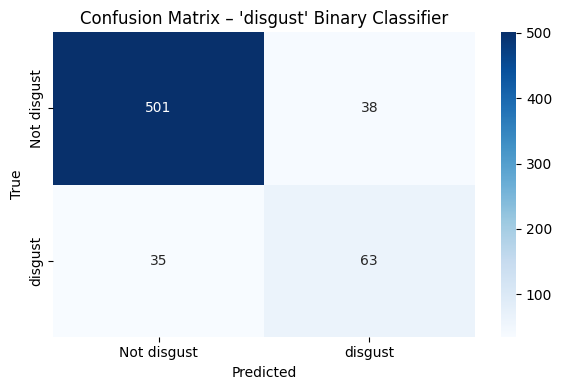

In [14]:
# ─── Block: Train "disgust" binary classifier ───

# Hyperparameters
input_dim   = X_train_emo['disgust'].shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
lr          = 1e-3
batch_size  = 36
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare DataLoaders
X_disgust_train = X_train_emo['disgust']
y_disgust_train = np.where(y_train  == "disgust", 1, 0)

X_disgust_test  = X_test_emo['disgust']
y_disgust_test  = np.where(y_test  == "disgust", 1, 0)

# Instantiate model, loss, and optimizer
mlp = MLPClassifier(max_iter=1000, random_state=42)
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (64,128)],
    "activation":         ["relu","tanh"],
    "alpha":              [1e-3],
    "learning_rate":      ["constant","adaptive"]
}
digust_grid = GridSearchCV(
    mlp,
    param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)
digust_grid.fit(X_disgust_train, y_disgust_train)

# 5) Evaluate on validation
y_pred = digust_grid.predict(X_disgust_test)


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_disgust_test, y_pred, target_names=['not disgust', 'disgust']))

# Compute confusion matrix
cm = confusion_matrix(y_disgust_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"disgust"}", "disgust"],
    yticklabels=[f"Not {"disgust"}", "disgust"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"disgust"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [15]:
# ─── Block: Train "fearful" binary classifier ───

y_train_f = np.where(y_train == "fearful", 1, 0)
y_test_f  = np.where(y_test  == "fearful", 1, 0)

balanced_ws = compute_class_weight(
    class_weight="balanced",
    classes=y_test.to_numpy(),
    y=y_train
)

class_weight = {0: 0.75, 1: 30}

model_fearful_svc = SVC(
    kernel="rbf",
    class_weight={0: 0.75, 1: 30},
    probability=True,
    random_state=42
)
model_fearful_svc.fit(X_train_emo["fearful"], y_train_f)
y_pred_fearful = model_fearful_svc.predict(X_test_emo["fearful"])
print(classification_report(y_test_f, y_pred_fearful, target_names=["not fearful","fearful"]))

              precision    recall  f1-score   support

 not fearful       0.95      0.92      0.93       531
     fearful       0.66      0.74      0.69       106

    accuracy                           0.89       637
   macro avg       0.80      0.83      0.81       637
weighted avg       0.90      0.89      0.89       637



Epoch 1/50 — Loss: 0.4480
Epoch 2/50 — Loss: 0.2885
Epoch 3/50 — Loss: 0.2060
Epoch 4/50 — Loss: 0.1504
Epoch 5/50 — Loss: 0.1098
Epoch 6/50 — Loss: 0.0742
Epoch 7/50 — Loss: 0.0457
Epoch 8/50 — Loss: 0.0270
Epoch 9/50 — Loss: 0.0159
Epoch 10/50 — Loss: 0.0100
Epoch 11/50 — Loss: 0.0114
Epoch 12/50 — Loss: 0.0117
Epoch 13/50 — Loss: 0.0049
Epoch 14/50 — Loss: 0.0032
Epoch 15/50 — Loss: 0.0017
Epoch 16/50 — Loss: 0.0011
Epoch 17/50 — Loss: 0.0008
Epoch 18/50 — Loss: 0.0007
Epoch 19/50 — Loss: 0.0006
Epoch 20/50 — Loss: 0.0005
Epoch 21/50 — Loss: 0.0005
Epoch 22/50 — Loss: 0.0004
Epoch 23/50 — Loss: 0.0004
Epoch 24/50 — Loss: 0.0004
Epoch 25/50 — Loss: 0.0003
Epoch 26/50 — Loss: 0.0003
Epoch 27/50 — Loss: 0.0003
Epoch 28/50 — Loss: 0.0002
Epoch 29/50 — Loss: 0.0002
Epoch 30/50 — Loss: 0.0002
Epoch 31/50 — Loss: 0.0002
Epoch 32/50 — Loss: 0.0002
Epoch 33/50 — Loss: 0.0002
Epoch 34/50 — Loss: 0.0002
Epoch 35/50 — Loss: 0.0002
Epoch 36/50 — Loss: 0.0001
Epoch 37/50 — Loss: 0.0001
Epoch 38/5

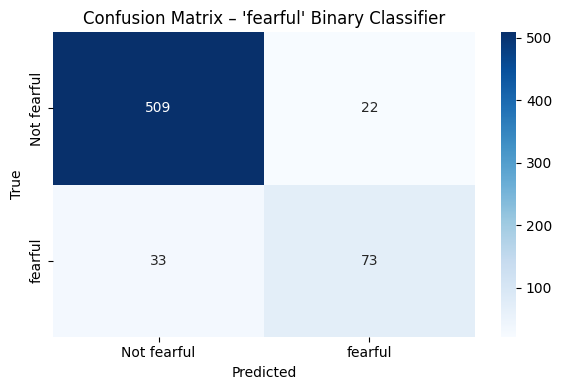

In [22]:
# ─── Block: Train "fearful" binary classifier ───
# Hyperparameters
input_dim   = X_train_emo['fearful'].shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
lr          = 1e-3
batch_size  = 36
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





# Prepare DataLoaders
X_fearful_train = torch.tensor(X_train_emo['fearful'], dtype=torch.float32)
y_fearful_train = torch.tensor((y_train == 'fearful').astype(float), dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_fearful_train, y_fearful_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


X_fearful_test  = torch.tensor(X_test_emo['fearful'], dtype=torch.float32)
y_fearful_test  = torch.tensor((y_test.to_numpy()  == 'fearful').astype(float), dtype=torch.float32).unsqueeze(1)
test_ds  = TensorDataset(X_fearful_test, y_fearful_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Instantiate model, loss, and optimizer
model_fearful = BinaryMLP(input_dim, hidden_dim1, hidden_dim2).to(device)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(model_fearful.parameters(), lr=lr)

# Training loop
for epoch in range(1, num_epochs+1):
    model_fearful.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_fearful(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")

# Evaluation
model_fearful.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model_fearful(xb).cpu().numpy()
        preds = (probs > 0.4).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(yb.numpy().flatten().tolist())


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['not fearful', 'fearful']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"fearful"}", "fearful"],
    yticklabels=[f"Not {"fearful"}", "fearful"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"fearful"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [ ]:
#if isinstance(model_fearful, torch.nn.Module):
        # Save PyTorch model weights
#        torch.save(model_fearful, "fearful_model_2.pt")
#else:
        # Save scikit-learn model
#        joblib.dump(model_fearful, "fearful_model_2.pkl")

Epoch 1/50 — Loss: 0.3406
Epoch 2/50 — Loss: 0.2059
Epoch 3/50 — Loss: 0.1544
Epoch 4/50 — Loss: 0.1201
Epoch 5/50 — Loss: 0.0861
Epoch 6/50 — Loss: 0.0769
Epoch 7/50 — Loss: 0.0507
Epoch 8/50 — Loss: 0.0394
Epoch 9/50 — Loss: 0.0254
Epoch 10/50 — Loss: 0.0287
Epoch 11/50 — Loss: 0.0221
Epoch 12/50 — Loss: 0.0187
Epoch 13/50 — Loss: 0.0049
Epoch 14/50 — Loss: 0.0028
Epoch 15/50 — Loss: 0.0018
Epoch 16/50 — Loss: 0.0013
Epoch 17/50 — Loss: 0.0011
Epoch 18/50 — Loss: 0.0009
Epoch 19/50 — Loss: 0.0007
Epoch 20/50 — Loss: 0.0006
Epoch 21/50 — Loss: 0.0005
Epoch 22/50 — Loss: 0.0004
Epoch 23/50 — Loss: 0.0004
Epoch 24/50 — Loss: 0.0003
Epoch 25/50 — Loss: 0.0003
Epoch 26/50 — Loss: 0.0003
Epoch 27/50 — Loss: 0.0003
Epoch 28/50 — Loss: 0.0002
Epoch 29/50 — Loss: 0.0002
Epoch 30/50 — Loss: 0.0002
Epoch 31/50 — Loss: 0.0002
Epoch 32/50 — Loss: 0.0002
Epoch 33/50 — Loss: 0.0002
Epoch 34/50 — Loss: 0.0001
Epoch 35/50 — Loss: 0.0001
Epoch 36/50 — Loss: 0.0001
Epoch 37/50 — Loss: 0.0001
Epoch 38/5

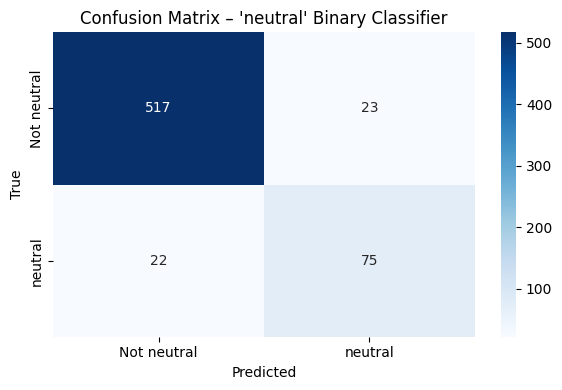

In [24]:
# ─── Block: Train "neutral" binary classifier ───

# Hyperparameters
input_dim   = X_train_emo['neutral'].shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
lr          = 1e-3
batch_size  = 32
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare DataLoaders
X_neutral_train = torch.tensor(X_train_emo['neutral'], dtype=torch.float32)
y_neutral_train = torch.tensor((y_train == 'neutral').astype(float), dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_neutral_train, y_neutral_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_neutral_test  = torch.tensor(X_test_emo['neutral'], dtype=torch.float32)
y_neutral_test  = torch.tensor((y_test.to_numpy()  == 'neutral').astype(float), dtype=torch.float32).unsqueeze(1)
test_ds  = TensorDataset(X_neutral_test, y_neutral_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Instantiate model, loss, and optimizer
model_neutral = BinaryMLP(input_dim, hidden_dim1, hidden_dim2).to(device)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(model_neutral.parameters(), lr=lr)

# Training loop
for epoch in range(1, num_epochs+1):
    model_neutral.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_neutral(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")

# Evaluation
model_neutral.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model_neutral(xb).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(yb.numpy().flatten().tolist())


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['not neutral', 'neutral']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"neutral"}", "neutral"],
    yticklabels=[f"Not {"neutral"}", "neutral"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"neutral"}' Binary Classifier")
plt.tight_layout()
plt.show()



              precision    recall  f1-score   support

 not neutral       0.96      0.96      0.96       540
     neutral       0.78      0.75      0.77        97

    accuracy                           0.93       637
   macro avg       0.87      0.86      0.86       637
weighted avg       0.93      0.93      0.93       637



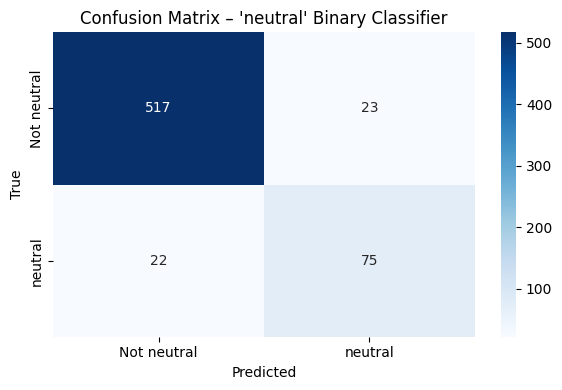

['neutral_pipeline.pkl']

In [27]:
import joblib
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics         import classification_report, confusion_matrix

# 1) Prepare your binary targets
#    Assuming y_train is your array of string labels and X_train_emo["neutral"] is your np.array
import numpy as np
y_train_neu = np.where(y_train == "neutral", 1, 0)
y_test_neu  = np.where(y_test  == "neutral", 1, 0)


# Convert X_train_emo["neutral"] to a DataFrame
X_train_neutral_df = pd.DataFrame(X_train_emo["neutral"], columns=emo_features["neutral"])
X_test_neutral_df = pd.DataFrame(X_test_emo["neutral"], columns=emo_features["neutral"])

# 2) Build the pipeline
neutral_pipe = Pipeline([
    # scale each feature to zero mean / unit var
    ("scaler", StandardScaler()),
    # a 2-layer MLP: 128→64→1 with sigmoid (via probability=True)
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-3,
        learning_rate_init=1e-3,
        solver="adam",
        max_iter=1000,         # roughly your 50 epochs × batch‐size steps
        random_state=42,
        verbose=False
    ))
])



# 3) Fit it
neutral_pipe.fit(X_train_emo["neutral"], y_train_neu)

# 4) Evaluate on the test set
y_pred_neu = neutral_pipe.predict(X_test_emo["neutral"])
neutral_pipe.fit(X_train_neutral_df, y_train_neu)
print(classification_report(y_test_neu, y_pred_neu, target_names=["not neutral","neutral"]))

y_pred_neu = neutral_pipe.predict(X_test_neutral_df)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"neutral"}", "neutral"],
    yticklabels=[f"Not {"neutral"}", "neutral"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"neutral"}' Binary Classifier")
plt.tight_layout()
plt.show()

# 5) Save the entire pipeline in one file
joblib.dump(neutral_pipe, "neutral_pipeline.pkl")


In [ ]:
#import joblib

#if isinstance(model_neutral, torch.nn.Module):
        # Save PyTorch model weights
#        torch.save(model_neutral, "neutral_model.pt")
#else:
        # Save scikit-learn model
#        joblib.dump(model_neutral, "neutral_model.pkl")

Epoch 1/50 — Loss: 0.3881
Epoch 2/50 — Loss: 0.2511
Epoch 3/50 — Loss: 0.1915
Epoch 4/50 — Loss: 0.1716
Epoch 5/50 — Loss: 0.1136
Epoch 6/50 — Loss: 0.0842
Epoch 7/50 — Loss: 0.0541
Epoch 8/50 — Loss: 0.0385
Epoch 9/50 — Loss: 0.0305
Epoch 10/50 — Loss: 0.0158
Epoch 11/50 — Loss: 0.0058
Epoch 12/50 — Loss: 0.0029
Epoch 13/50 — Loss: 0.0018
Epoch 14/50 — Loss: 0.0014
Epoch 15/50 — Loss: 0.0011
Epoch 16/50 — Loss: 0.0009
Epoch 17/50 — Loss: 0.0008
Epoch 18/50 — Loss: 0.0006
Epoch 19/50 — Loss: 0.0006
Epoch 20/50 — Loss: 0.0005
Epoch 21/50 — Loss: 0.0004
Epoch 22/50 — Loss: 0.0004
Epoch 23/50 — Loss: 0.0003
Epoch 24/50 — Loss: 0.0003
Epoch 25/50 — Loss: 0.0003
Epoch 26/50 — Loss: 0.0002
Epoch 27/50 — Loss: 0.0002
Epoch 28/50 — Loss: 0.0002
Epoch 29/50 — Loss: 0.0002
Epoch 30/50 — Loss: 0.0002
Epoch 31/50 — Loss: 0.0002
Epoch 32/50 — Loss: 0.0002
Epoch 33/50 — Loss: 0.0001
Epoch 34/50 — Loss: 0.0001
Epoch 35/50 — Loss: 0.0001
Epoch 36/50 — Loss: 0.0001
Epoch 37/50 — Loss: 0.0001
Epoch 38/5

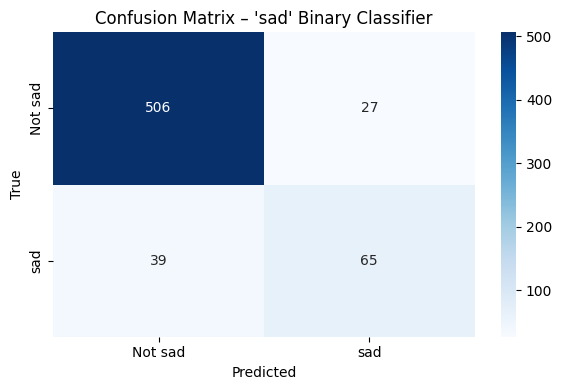

In [29]:
# ─── Block: Train "sad" binary classifier ───

# Hyperparameters
input_dim   = X_train_emo['sad'].shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
lr          = 1e-3
batch_size  = 36
num_epochs  = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare DataLoaders
X_sad_train = torch.tensor(X_train_emo['sad'], dtype=torch.float32)
y_sad_train = torch.tensor((y_train == 'sad').astype(float), dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_sad_train, y_sad_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_sad_test  = torch.tensor(X_test_emo['sad'], dtype=torch.float32)
y_sad_test  = torch.tensor((y_test.to_numpy()  == 'sad').astype(float), dtype=torch.float32).unsqueeze(1)
test_ds  = TensorDataset(X_sad_test, y_sad_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Instantiate model, loss, and optimizer
model_sad = BinaryMLP(input_dim, hidden_dim1, hidden_dim2).to(device)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(model_sad.parameters(), lr=lr)

# Training loop
for epoch in range(1, num_epochs+1):
    model_sad.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_sad(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")

# Evaluation
model_sad.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model_sad(xb).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(yb.numpy().flatten().tolist())


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['not sad', 'sad']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"sad"}", "sad"],
    yticklabels=[f"Not {"sad"}", "sad"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"sad"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [30]:
ensemble_models = {
    "happy":    model_happy,    #SVC
    "angry":    model_angry,    #MLP
    "disgust":  model_disgust_svc,  #SVC
    "fearful":  model_fearful,  #SVC
    "neutral":  model_neutral,  #MLP
    "sad":      model_sad       #MLP
}

In [31]:
# for name, model in ensemble_models.items():
#     if isinstance(model, torch.nn.Module):
#         # Save PyTorch model weights
#         torch.save(model, name + "_model.pt")
#     else:
#         #Save scikit-learn model
#         joblib.dump(model, name + "_model.pkl")

In [32]:
# Assume:
#   X_test_emo = { emo: numpy array shape (N, feat_dim) for each emotion }
#   y_test     = array of true labels, shape (N,)

probs_dict = {}
for emo, clf in ensemble_models.items():
    X_emo = X_test_emo[emo]
    print(emo)
    
    if isinstance(clf, torch.nn.Module):
        # PyTorch model: run through sigmoid net
        clf.eval()
        with torch.no_grad():
            t = torch.tensor(X_emo, dtype=torch.float32).to(device)
            probs = clf(t).cpu().numpy().flatten()
    else:
        # sklearn‐style model
        probs = clf.predict_proba(X_emo)[:, 1]
    
    probs_dict[f"{emo}_prob"] = probs

# Final ensemble DataFrame
df_ensemble = pd.DataFrame(probs_dict)
df_ensemble["true_label"] = y_test
df_ensemble.head()

print(df_ensemble)


happy
angry
disgust
fearful
neutral
sad
       happy_prob    angry_prob  disgust_prob  fearful_prob  neutral_prob  \
0    1.000000e+00  6.803436e-10      0.050604  1.687377e-09  1.077895e-06   
1    2.694463e-04  9.971602e-01      0.014275  1.046291e-05  1.522156e-23   
2    9.894933e-01  1.614300e-03      0.001452  4.392037e-08  4.664755e-11   
3    1.727344e-08  1.621854e-07      0.037414  6.789596e-07  3.572147e-01   
4    2.664821e-07  1.118772e-03      0.016765  9.995152e-01  1.256477e-18   
..            ...           ...           ...           ...           ...   
632  8.503553e-11  7.918910e-04      0.993621  2.769714e-10  2.116534e-13   
633  4.578169e-07  4.349044e-14      0.001979  9.996234e-01  9.571579e-27   
634  7.484825e-09  2.495600e-09      0.035070  5.294548e-11  9.977770e-01   
635  2.034687e-08  4.782915e-11      0.706414  8.135769e-10  3.327064e-03   
636  7.871353e-07  9.996597e-01      0.040077  4.558257e-09  3.573106e-08   

         sad_prob true_label  
0   

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode string labels into integers
le = LabelEncoder()
y_meta = le.fit_transform(df_ensemble["true_label"])
x_meta = df_ensemble.drop(columns="true_label")

scaler2 = StandardScaler().fit(x_meta)
x_meta = scaler2.transform(x_meta)

# Split (or reuse your previous test split)
Xm_train, Xm_val, ym_train, ym_val = train_test_split(
    x_meta, y_meta, test_size=0.2, stratify=y_meta, random_state=42
)

meta = LogisticRegression(max_iter=500)
meta.fit(Xm_train, ym_train)

print("Meta‑model val accuracy:", meta.score(Xm_val, ym_val))


Meta‑model val accuracy: 0.6875


In [ ]:
#if isinstance(meta, torch.nn.Module):
        # Save PyTorch model weights
#        torch.save(meta, "metaLogisticregression.pt")
#else:
        # Save scikit-learn model
#        joblib.dump(meta, "metaLogisticregression.pkl")

In [ ]:
#if isinstance(grid, torch.nn.Module):
        # Save PyTorch model weights
#        torch.save(grid, "metaMLPGrid.pt")
#else:
        # Save scikit-learn model
#        joblib.dump(grid, "metaMLPGrid.pkl")

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', nan]


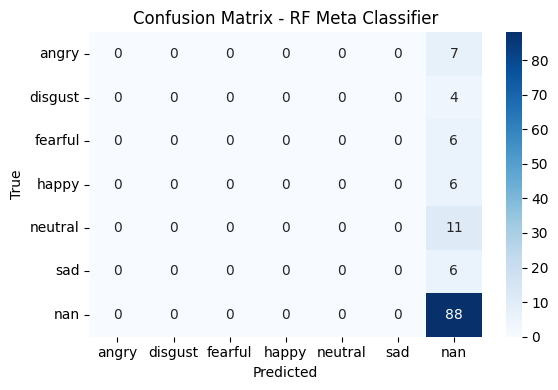

In [40]:
model_meta_RF = RandomForestClassifier(n_estimators=100, random_state=42)

model_meta_RF.fit(Xm_train, ym_train)

y_pred_meta = model_meta_RF.predict(Xm_val)
# Ensure target_names is a list of class labels
target_names = list(le.classes_)
print(target_names)
#print(classification_report(ym_val, y_pred_meta, target_names=target_names))

cmb = confusion_matrix(ym_val, y_pred_meta)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cmb, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - RF Meta Classifier")
plt.tight_layout()
plt.show()

In [ ]:
# ─── Cell: Meta‑Model Training & Evaluation with Fitted LabelEncoder ───



# 4) Define grid & fit
mlp = MLPClassifier(max_iter=300, random_state=42)
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (128,64)],
    "activation":         ["relu","tanh"],
    "alpha":              [1e-4, 1e-3, 1e-2],
    "learning_rate":      ["constant","adaptive"]
}
grid = GridSearchCV(
    mlp,
    param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)
grid.fit(Xm_train, ym_train)

# 5) Evaluate on validation
y_pred = grid.predict(Xm_val)

print("\n=== Validation Classification Report ===")
print(classification_report(
    ym_val,
    y_pred,
    target_names=le.classes_
))

cm = confusion_matrix(ym_val, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – RF Meta Classifier")
plt.tight_layout()
plt.show()